In [53]:
import numpy as np
import sys
sys.path.insert(0, '/Library/Application Support/MWorks/Scripting/Python')
from mworks.data import MWKFile
import matplotlib.pyplot as plt
import matplotlib.style as style 
import pandas as pd

style.use('seaborn-poster') 
style.use('seaborn-white')

In [54]:
username = 'aidapiccato'
dir_path = '/Users/%s/PyCharmProjects/concentration/concentration-game-mworks' % username
subject_id = 0


In [55]:
## sync times 
ITI = 1
TRIAL_INIT = 2
FLIP_CARD_A = 3
FLIP_CARD_B = 4
FEEDBACK = 5
TRIAL_END = 6

In [103]:
class Unpack():    
    def __init__(self, fn):
        fpath = '/Users/%s/Documents/MWorks/Data' % username
        self.fn = fn        
        self.f =  MWKFile('%s/%s' % (fpath, fn))
        self.f.open()
        self.codec = self.f.codec
        self.codenames = ['card_b', 'card_a',  'grid', 'grid_dims', 'inv_grid', 'n_pairs', 'block_index'] 
        self.start_sync_t, self.end_sync_t = self.get_sync_times()
        self.n_trials = len(self.start_sync_t)
        print('Collecting %d trials of data' % self.n_trials)
        self.avg_trial_dur = (self.end_sync_t - self.start_sync_t) / 10**6
        print('Average trial duration: %f seconds' % np.mean(self.avg_trial_dur))        
        self.scalar = self.get_scalar_data()
        # self.analog = self.get_analog_data()

                
    def get_scalar_data(self):
        data_scalar = {'dur': [], 'card_a_img': [], 'card_b_img': [], 'card_c': [], 'dist_a_b': [], 'dist_b_c': []}
        
        for c in self.codenames:
            data_scalar[c] = []

        for trial in range(self.n_trials):            
            start_t, end_t = np.long(self.start_sync_t[trial]), np.long(self.end_sync_t[trial])
            trial_events = self.f.get_events(codes = self.codenames, time_range=[start_t, end_t])
            trial_events = np.asarray([[e.code, e.time, e.data] for e in trial_events])         
            # trial duration        
            data_scalar['dur'].append((end_t - start_t)/10**6)        
            for ci, c in enumerate(self.codenames): # currently this is only selecting card_b                
                code = self.f.reverse_codec[c]
                code_events = trial_events[np.where(trial_events[:, 0] == code)[0], 2]
                data_scalar[c].append(code_events[0])                    
            card_a = data_scalar['card_a'][trial]
            card_b = data_scalar['card_b'][trial]
            grid = np.asarray(data_scalar['grid'][trial])
            match = np.where(grid == grid[card_a])[0]            
            card_c = match[match != card_a]    
            
            data_scalar['card_c'].append(card_c)
            
            data_scalar['card_a_img'].append(data_scalar['grid'][trial][card_a])
            data_scalar['card_b_img'].append(data_scalar['grid'][trial][card_b])
            
            # distance between locations of card a and b
            data_scalar['dist_a_b'].append(self.get_dist(card_a, card_b, data_scalar['grid_dims'][trial]))
            
            # distance between locations of card b and correct card
            data_scalar['dist_b_c'].append(self.get_dist(card_b, card_c, data_scalar['grid_dims'][trial]))
            
        data_scalar['rt'] = self.get_reaction_times() 
        
        data_scalar = pd.DataFrame(data_scalar)
        return data_scalar
    
    def get_analog_data(self):
        data_analog = {'location': [], 'img': [], 'trial': [], 'time': [], 'selected': []} 
        
        for t in range(self.n_trials):
            start_t, end_t = np.long(self.start_sync_t[t]), np.long(self.end_sync_t[t])
            trial_events = self.f.get_events(codes=['sync'], time_range=[start_t, end_t])
            trial_events = np.asarray([[e.code, e.time, e.data] for e in trial_events])
            card_a_t = trial_events[np.where(trial_events[:, 2] == FLIP_CARD_A)[0], 1]
            card_b_t = trial_events[np.where(trial_events[:, 2] == FLIP_CARD_B)[0], 1]
            
            data_analog['location'].append(self.scalar['card_a'])
            data_analog['img'].append(self.scalar['card_a_img'])
            data_analog['trial'].append(t)
            data_analog['time'].append(card_a_t)
            data_analog['selected'].append(False)
            
            
            data_analog['location'].append(self.scalar['card_b'][t])
            data_analog['img'].append(self.scalar['card_b_img'])
            data_analog['trial'].append(t)
            data_analog['time'].append(card_b_t)
            data_analog['selected'].append(True)
            
        data_analog = pd.DataFrame(data_analog)
            
                                               
        return data_analog
    
    def get_sync_times(self): 
        sync_events = self.f.get_events(codes=['sync'])
        sync_events = np.asarray([[e.data, e.time] for e in sync_events])        
        end_sync_t = sync_events[np.where(sync_events[:, 0] == TRIAL_END)[0], 1]
        start_sync_t = sync_events[np.where(sync_events[:, 0] == TRIAL_INIT)[0], 1]
        start_sync_t = start_sync_t[:len(end_sync_t)]
        return start_sync_t, end_sync_t
    
    def get_dist(self, card_a, card_b, grid_dims): 
        card_a_loc = np.asarray([np.floor(card_a/grid_dims[1]), card_a%grid_dims[1]])
        card_b_loc = np.asarray([np.floor(card_b/grid_dims[1]), card_b%grid_dims[1]])
        return np.linalg.norm(card_a_loc - card_b_loc)
    
    def get_reaction_times(self):
        rts = []
        for trial in range(self.n_trials):
            start_t, end_t = np.long(self.start_sync_t[trial]), np.long(self.end_sync_t[trial])
            sync = self.f.get_events(codes = ['sync'], time_range=[start_t, end_t])
            sync = np.asarray([[e.data, e.time] for e in sync])                
            flip_card_a = sync[np.where(sync[:, 0] == FLIP_CARD_A)[0], 1]
            flip_card_b = sync[np.where(sync[:, 0] == FLIP_CARD_B)[0], 1]                    
            if len(flip_card_b) == 0:
                flip_card_b = [flip_card_a]
            rt = np.long(flip_card_b[0]) - np.long(flip_card_a[0])
            
            rts.append(rt/10**6)
        return rts

In [104]:
fn = "aidapiccato-concentration-ios-20200122-150945.mwk2"
unpack = Unpack(fn)

Average trial duration: 1.660950 seconds


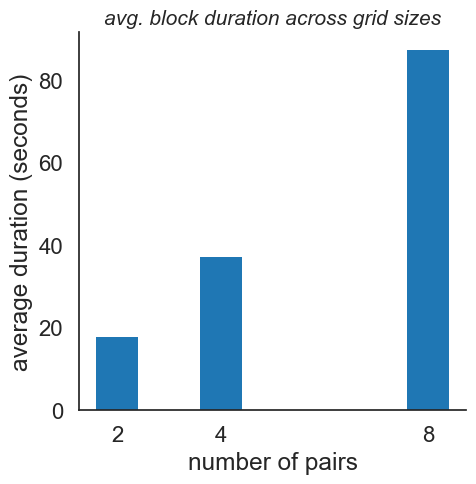

In [82]:
# duration of block averaged across grid sizes
block_avg_dur = unpack.scalar.groupby('n_pairs')['dur'].sum()/unpack.scalar.groupby('n_pairs')['block_index'].nunique()
f, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
ax.bar(block_avg_dur.keys(), block_avg_dur)
ax.set_xticks(block_avg_dur.keys())
ax.set_xlabel('number of pairs')
ax.set_ylabel('average duration (seconds)')
ax.set_title('avg. block duration across grid sizes')
prettify(ax)
plt.show()
 


In [43]:
def prettify(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.title.set_style('italic')
    ax.title.set_size(15)